In [47]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    print(p)

optimization/btest000.pickle
optimization/btest001.pickle
optimization/btest002.pickle
optimization/btest003.pickle
optimization/btest004.pickle
optimization/btest005.pickle
optimization/btest006.pickle
optimization/btest007.pickle
optimization/btest008.pickle
optimization/btest009.pickle
optimization/btest010.pickle
optimization/btest011.pickle
optimization/btest012.pickle
optimization/btest013.pickle
optimization/btest014.pickle
optimization/btest015.pickle
optimization/btest016.pickle
optimization/btest017.pickle


In [75]:
from backtest import DataParser, MovingWindow
import numpy as np
import lightgbm as lgb
from lightgbm import log_evaluation
from sklearn.metrics import mean_absolute_error, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from indicators import ZigZag


def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), False

fsize = 15
tfdict = {"M5":0, "M15":1, "H1":2}
zz = ZigZag()
Xl, Xs, yl, ys, odates, poslist, targets = [], [], [], [], [], [], []
for btest in btests:
    print(btest.cfg.ticker, end=" ")
    hist_pd, hist = DataParser(btest.cfg).load()
    mw = MovingWindow(hist, fsize+2)
    print(len(btest.positions))
    for pos in btest.positions[1:]:
        f, _ = mw(pos.open_indx)
        fo = f.Open[:-2]/f.Open[-2]
        fc = f.Close[:-2]/f.Open[:-2]
        fh = f.High[:-2]/f.Open[:-2]
        fl = f.Low[:-2]/f.Open[:-2]
        fv = f.Volume[:-2]/f.Volume[:-2].mean()
        odate = pd.to_datetime(pos.open_date)
        odate = odate.year*10000 + odate.month*100 + odate.day
        if pos.dir == 1:
            Xl.append(np.hstack([fc, fo, fl, fh, fv, btest.cfg.stops_processor.func.cfg.sl, btest.cfg.trailing_stop_rate, odate, tfdict[btest.cfg.period]]))
            yl.append(pos.profit)
        else:
            Xs.append(np.hstack([2-fc, 2-fo, 2-fl, 2-fh, fv, btest.cfg.stops_processor.func.cfg.sl, btest.cfg.trailing_stop_rate, odate, tfdict[btest.cfg.period]])) 
            ys.append(pos.profit) 
        poslist.append(pos)
        targets.append(pos.dir*(hist.Close[pos.open_indx:pos.open_indx+fsize].mean() - hist.Open[pos.open_indx])/hist.Open[pos.open_indx]*100)
        
Xs, Xl = np.array(Xs), np.array(Xl)
ys, yl = np.array(ys), np.array(yl)
odates = np.array(odates)
targets = np.clip(np.array(targets), -99, 99)


# ids2add = np.random.choice(np.arange(Xs.shape[0]), size=Xl.shape[0] - Xs.shape[0])
# Xs = np.vstack([Xs, Xs[ids2add]])
# ys = np.hstack([ys, ys[ids2add]])
X = np.vstack([Xs, Xl])
y = np.hstack([ys, yl])
print(Xs.shape, Xl.shape, X.shape, ys.shape, yl.shape, y.shape)

BTCUSD 497
ETHUSD 607
BTCUSD 355
ETHUSD 433
BTCUSD 297
ETHUSD 359
BTCUSD 649
ETHUSD 740
BTCUSD 479
ETHUSD 568
BTCUSD 424
ETHUSD 501
BTCUSD 843
ETHUSD 903
BTCUSD 697
ETHUSD 757
BTCUSD 629
ETHUSD 677
(5044, 79) (5353, 79) (10397, 79) (5044,) (5353,) (10397,)


In [27]:
print(" ".join(map("{:6.4f}".format, X[1000])))

0.9960 0.9998 0.9973 1.0050 0.9752 1.0088 1.0131 0.9992 1.0012 0.9916 1.0083 1.0177 1.0211 0.9916 1.0121 0.9601 0.9559 0.9558 0.9529 0.9582 0.9323 0.9416 0.9555 0.9546 0.9559 0.9472 0.9559 0.9745 0.9961 0.9877 1.0037 1.0075 1.0001 1.0062 1.0001 1.0109 1.0138 1.0024 1.0056 1.0011 1.0094 1.0256 1.0249 1.0023 1.0194 0.9960 0.9996 0.9944 0.9999 0.9752 0.9917 1.0000 0.9972 1.0000 0.9914 0.9998 1.0000 0.9999 0.9914 1.0000 2.0000 0.0100 20181119.0000 2.0000


In [4]:
print(" ".join(map("{:6.4f}".format, targets[:10])))

-0.7513 1.8025 -0.2653 -1.8339 0.5343 -0.0876 2.7392 0.5846 -1.8473 -0.6409


In [5]:
print(" ".join(map("{:6.4f}".format, y[:10])))

10.7489 -1.9495 11.7240 0.3391 -3.1188 -2.8162 5.3477 -3.8664 8.6496 -0.8199


7790 2607
000 profit M5 :   +0.0 ->    +0.0 --
000 profit M15:   +0.0 ->    +0.0 --
000 profit H1 :+1418.5 -> +1740.9 OK
000 mae_train: 3.37 mae_test: 3.67
7795 2602
001 profit M5 :   +0.0 ->    +0.0 --
001 profit M15:   +0.0 ->    +0.0 --
001 profit H1 : +841.1 ->  +595.1 --
001 mae_train: 3.40 mae_test: 3.73
7790 2607
002 profit M5 :   +0.0 ->    +0.0 --
002 profit M15:   +0.0 ->    +0.0 --
002 profit H1 :+2241.2 -> +2614.6 OK
002 mae_train: 3.29 mae_test: 3.90
7794 2603
003 profit M5 :   +0.0 ->    +0.0 --
003 profit M15:   +0.0 ->    +0.0 --
003 profit H1 :+1610.4 -> +2037.2 OK
003 mae_train: 3.38 mae_test: 3.85
7798 2599
004 profit M5 :   +0.0 ->    +0.0 --
004 profit M15:   +0.0 ->    +0.0 --
004 profit H1 : +937.5 -> +1191.6 OK
004 mae_train: 3.48 mae_test: 3.47
7796 2601
005 profit M5 :   +0.0 ->    +0.0 --
005 profit M15:   +0.0 ->    +0.0 --
005 profit H1 : -260.8 ->  +108.6 OK
005 mae_train: 3.59 mae_test: 3.42
7794 2603
006 profit M5 :   +0.0 ->    +0.0 --
006 profit M15:  

/tmp/ipykernel_67517/2836750767.py:84: RuntimeWarning: invalid value encountered in divide
  print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))


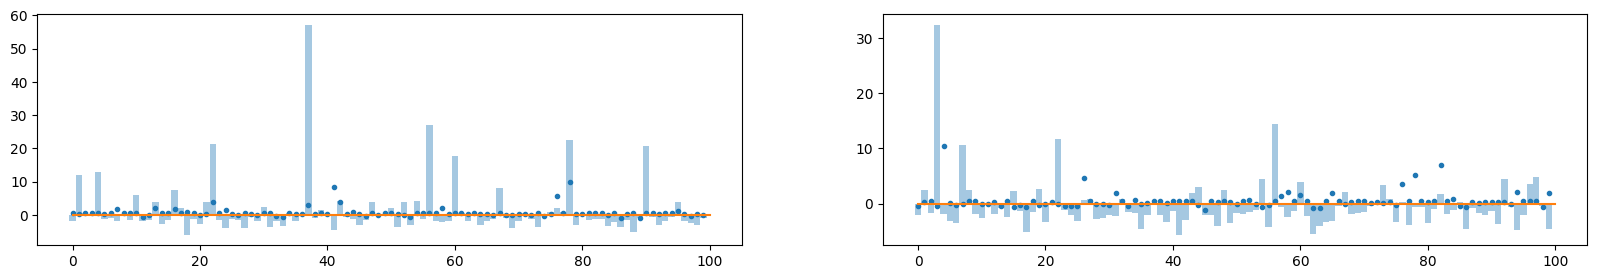

In [77]:
nitrers = 10
test_split = 0.25
id2tf = {v:k for k, v in tfdict.items()}

pprofits, gprofits, metrics = np.zeros((3, nitrers)), np.zeros((3, nitrers)), np.zeros((2, nitrers))
for i in range(nitrers):
    ids = np.arange(X.shape[0])
    # np.random.shuffle(ids)
    test_size = int(X.shape[0]*test_split)
    ids_test, odates_testset, odates = [], set(), X[:, -2]
    while len(ids_test) < test_size:
        ix = np.random.randint(0, X.shape[0])
        d = odates[ix]
        if d not in odates_testset:
            ii = ids[odates == d]
            ids_test += ii.tolist()
            odates_testset.add(d)
    ids_train = [ix for ix in ids if ix not in ids_test]   
    np.random.shuffle(ids_train) 
    np.random.shuffle(ids_test) 
        
    # ids_test, ids_train = ids[:test_size], ids[test_size:]
    X_train, X_test, y_train, y_test, profs_test = X[ids_train], X[ids_test], y[ids_train], y[ids_test], y[ids_test]
    tf_test = X_test[:, -1]
    X_train = X_train[:, :-2]
    X_test = X_test[:, :-2]

    # profs_test = y_test
    # profs_train = y_train
    # y_train = (y_train > 0).astype(int)
    # y_test = (y_test > 0).astype(int)

    # scaler = StandardScaler() 
    # scaler.fit(X_train) 
    # X_train = scaler.transform(X_train) 
    # X_test = scaler.transform(X_test) 
    
    # for _ in range(2):
    #     y_add = y_train + (np.random.random(y_train.shape)-0.5)*0.1
    #     X_train = np.vstack([X_train, X_train])
    #     y_train = np.hstack([y_train, y_add])
    
    print(X_train.shape[0], X_test.shape[0])
    # evals_result = {}
    # model = lgb.train(params=dict(objective="binary", 
    #                             # metric="auc",
    #                             # num_leaves=2, 
    #                             max_depth=3,
    #                             verbose=-1), 
    #                   train_set=lgb.Dataset(X_train, label=y_train),
    #                   valid_sets=[lgb.Dataset(X_test, label=y_test)],
    #                   num_boost_round=500,
    #                   feval=lgb_f1_score,
    #                   # evals_result=evals_result,
    #                   # verbose_eval=False,
    #                   callbacks=[log_evaluation(-1)]
    #                   )
    # lgb.plot_metric(evals_result, metric='f1')

    model = RandomForestRegressor(max_depth=3, n_estimators=300, min_samples_leaf=30, n_jobs=-1)
    model.fit(X_train, y_train)
    threshold = -0.1
    if len(X_train):
        # p_train = model.predict(X_train)
        p_train = model.predict(X_train)
        # threshold = np.percentile(p_train, 10)
        metrics[0, i] = mean_absolute_error(p_train, y_train)
    # p_test = model.predict(X_test)
    p_test = model.predict(X_test)
    metrics[1, i] = mean_absolute_error(p_test, y_test)

    for j in range(3):
        ids = tf_test == j
        pprofits[j, i] = (profs_test[ids]*(p_test[ids]>threshold)).sum()
        gprofits[j, i] = profs_test[ids].sum()
        print(f"{i:03} profit {id2tf[j]:3}:{gprofits[j, i]:+7.1f} -> {pprofits[j, i]:+7.1f} {'OK' if pprofits[j, i] > gprofits[j, i] else '--'}")
    print(f"{i:03} mae_train: {metrics[0, i]:4.2f} mae_test: {metrics[1, i]:4.2f}")
    
pprofs_mean = pprofits.mean(1)
gprofs_mean = gprofits.mean(1)
f1_mean = metrics.mean(1)

print(gprofs_mean, " -> ", pprofs_mean)
print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))
print(f"mae_train: {f1_mean[0]:4.2f} mae_test: {f1_mean[1]:4.2f} ration: {f1_mean[1]/f1_mean[0]:4.2f}")
print(f"av. profit boost: {(pprofits.mean() - gprofits.mean())/gprofits.mean()}")

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])
plt.subplot(1, 2, 2)
plt.plot(p_test[:100], ".")
plt.bar(np.arange(100), y_test[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])

009 profit M5 :   +0.0 ->    +0.0 --
009 profit M15:   +0.0 ->    +0.0 --
009 profit H1 : +894.3 ->  +934.4 OK
[   0.            0.         1690.30214464]  ->  [   0.            0.         1832.42073071]
[       nan        nan 0.08407881]
av. profit boost: 0.08407880598315795


/tmp/ipykernel_67517/1576227013.py:12: RuntimeWarning: invalid value encountered in divide
  print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))


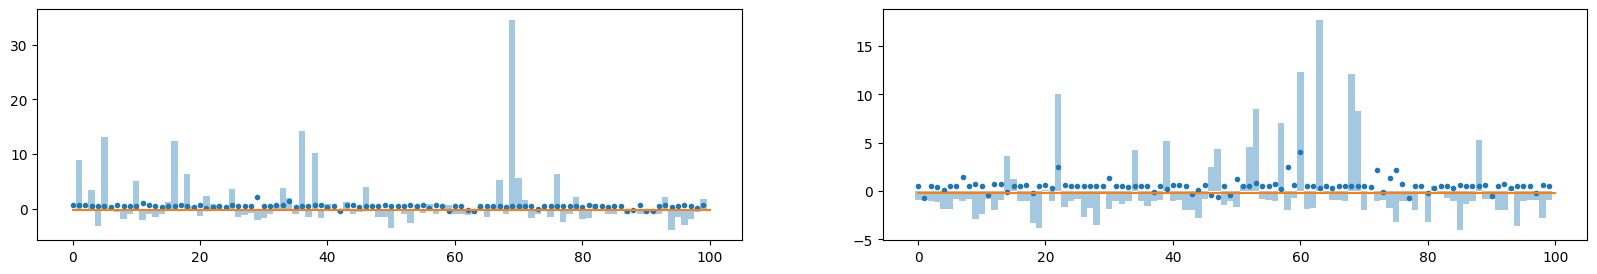

In [42]:
threshold = -0.2
for j in range(3):
    ids = tf_test == j
    pprofits[j, i] = (profs_test[ids]*(p_test[ids]>threshold)).sum()
    gprofits[j, i] = profs_test[ids].sum()
    print(f"{i:03} profit {id2tf[j]:3}:{gprofits[j, i]:+7.1f} -> {pprofits[j, i]:+7.1f} {'OK' if pprofits[j, i] > gprofits[j, i] else '--'}")
    
pprofs_mean = pprofits.mean(1)
gprofs_mean = gprofits.mean(1)

print(gprofs_mean, " -> ", pprofs_mean)
print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))
print(f"av. profit boost: {(pprofits.mean() - gprofits.mean())/gprofits.mean()}")

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])
plt.subplot(1, 2, 2)
plt.plot(p_test[:100], ".")
plt.bar(np.arange(100), y_test[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])

In [33]:
set(X_train[:, -1].astype(int)).intersection(set(X_test[:, -1].astype(int)))

{1, 2, 4}

In [43]:
print(" ".join(map("{:6.4f}".format, model.feature_importances_)))

0.0074 0.0004 0.0014 0.0009 0.0022 0.0258 0.0007 0.0042 0.0000 0.0000 0.0006 0.0051 0.0244 0.0123 0.0029 0.0005 0.0009 0.0000 0.0019 0.0038 0.0001 0.0000 0.0027 0.0003 0.0008 0.0059 0.0047 0.0146 0.0227 0.0058 0.0061 0.0192 0.0102 0.0252 0.0218 0.1189 0.0129 0.0390 0.0000 0.0092 0.0094 0.1496 0.0610 0.0001 0.0300 0.0015 0.0039 0.0096 0.0095 0.0869 0.0426 0.0008 0.0080 0.0287 0.0008 0.0006 0.0173 0.0058 0.0686 0.0197 0.0011 0.0028 0.0016 0.0018 0.0010 0.0024 0.0009 0.0016 0.0014 0.0017 0.0011 0.0079 0.0011 0.0000 0.0024 0.0010 0.0000


In [391]:
y_test.sum(), (p_test>threshold).sum(), p_test.shape[0], y_test.shape[0]

(1112, 3653, 3682, 3682)

In [ ]:
import mplfinance as mpf

ticker = "GAZP"
tf = "H1"
hist_pd, hist = DataParser(
    EasyDict(
        date_start="2008-01-01",
        period=tf,
        ticker=ticker,
        data_type="metatrader"
        )).load()

for i in ids_test:
    pos = poslist[i]
    if pos.ticker == ticker:
        prediction = model.predict_proba([X[i, :-1]])[0][1]
        if prediction < threshold:
            print(pos.ticker, pos.open_date, prediction)
            d2 = pd.to_datetime(pos.close_date)
            d1 = pd.to_datetime(pos.open_date)
            d0 = d1 - pd.DateOffset(days=3)
            hist2plot = hist_pd.loc[d0:d2]
            fig = mpf.plot(hist2plot, 
                type='candle', 
                block=False)

In [47]:
prediction

array([[0.49287947, 0.50712053]])